<a href="https://colab.research.google.com/github/PashaIanko/Kaggle.ParisHousingPrices/blob/better_outlier_clean/3_model_preparation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

## Packages

In [1]:
from google.colab import drive
# Datasets
import pandas as pd
# Numerics
import numpy as np
# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
# Preprocessing & pipelines
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
# Data management
from sklearn.model_selection import train_test_split
# Other
import os

from sklearn.metrics import mean_squared_error

pd.set_option('display.max_columns', None)

In [4]:
%%capture
GIT_DOWNLOAD_PATH = 'https://raw.githubusercontent.com/PashaIanko/Sklearn-Utils/main/'
FILES_LIST = [
    'path_manager.py',
    'sklearn_transformers.py',
    'sklearn_utils.py',
    'model.py'
]
GDRIVE_PATH = '/content/gdrive/MyDrive/'
PREPROC_TRIAL = 3
MODELS_TRIAL = 3
COMPETITION_PATH = GDRIVE_PATH + 'ML/Competitions/10.ParisHousePrices/'
# --------------------------------------------------
try:
    from nbpep8.nbpep8 import pep8
except ModuleNotFoundError:
    !pip install pycodestyle
    !pip install --index-url https://test.pypi.org/simple/ nbpep8
from nbpep8.nbpep8 import pep8
# ---------------------------------------
def download_files(url_dict):
    for file, url in url_dict.items():
        print(f'Downloading {file}')
        !wget -O {file} {url} {file}
url_dict = {file: GIT_DOWNLOAD_PATH + file for file in FILES_LIST}
print('a')
download_files(url_dict)
# ---------------------------------------
import importlib
import path_manager
import sklearn_utils
import sklearn_transformers
import model
def reload_all(modules_list_):
    for module in modules_list_:
        importlib.reload(module)
MODULES_LIST = [
    path_manager,
    sklearn_utils,
    sklearn_transformers,
    model
]
reload_all(MODULES_LIST)
# ---------------------------------------
from path_manager import PathManager
from model import Model
from sklearn_utils import nan_statistics
from sklearn_utils import boxplot_regression
from sklearn_utils import get_correlated_attributes
from sklearn_utils import visualize_datasets_distributions
from sklearn_transformers import ColumnDropper
from sklearn_transformers import LogTransformer
# ---------------------------------------
from google.colab import drive
drive.mount('/content/gdrive')
manager = PathManager(
    competition_path=COMPETITION_PATH,
    preprocessing_trial=PREPROC_TRIAL,
    models_trial=MODELS_TRIAL
)
manager.setup_paths()

## Functions

In [5]:
def report_model(model, X, Y):
    preds = model.predict(X)
    print(mean_squared_error(y_true=Y, y_pred=preds, squared=False))

# Download the data

In [6]:
df_train = pd.read_csv(f'{manager.data_trial_path}/train_processed.csv', index_col=0)
df_val = pd.read_csv(f'{manager.data_trial_path}/val_processed.csv', index_col=0)
df_test = pd.read_csv(f'{manager.data_trial_path}/test_processed.csv', index_col=0)
df_submission = pd.read_csv(f'{manager.data_trial_path}/submission_processed.csv', index_col=0)

In [7]:
# I forgot to re-insert the original index of submission dataset
submission_index = pd.read_csv(f'{manager.data_root_path}/sample_submission.csv', index_col='id').index

In [8]:
X_train = df_train.iloc[:, :-1]
Y_train = df_train.iloc[:, -1]
X_train.max().max()

1.0000000000000002

In [9]:
X_val = df_val.iloc[:, :-1]
Y_val = df_val.iloc[:, -1]

X_test = df_test.iloc[:, :-1]
Y_test = df_test.iloc[:, -1]

X_submission = df_submission.iloc[:, :]

X_trainval = np.vstack([X_train, X_val])
Y_trainval = np.concatenate([Y_train, Y_val])

In [10]:
Xs = [
    X_train,
    X_val,
    X_test,
    X_submission
]

Ys = [
    Y_train,
    Y_val,
    Y_test,
    None
]

# Find the baseline model

## Random forest regressor

In [13]:
Xs[0].shape, manager.data_trial_path

((14361, 47),
 '/content/gdrive/MyDrive/ML/Competitions/10.ParisHousePrices/Data/preproc_trial_3')

In [21]:
pd.concat([df_train, df_val, df_test]).shape

(22440, 48)

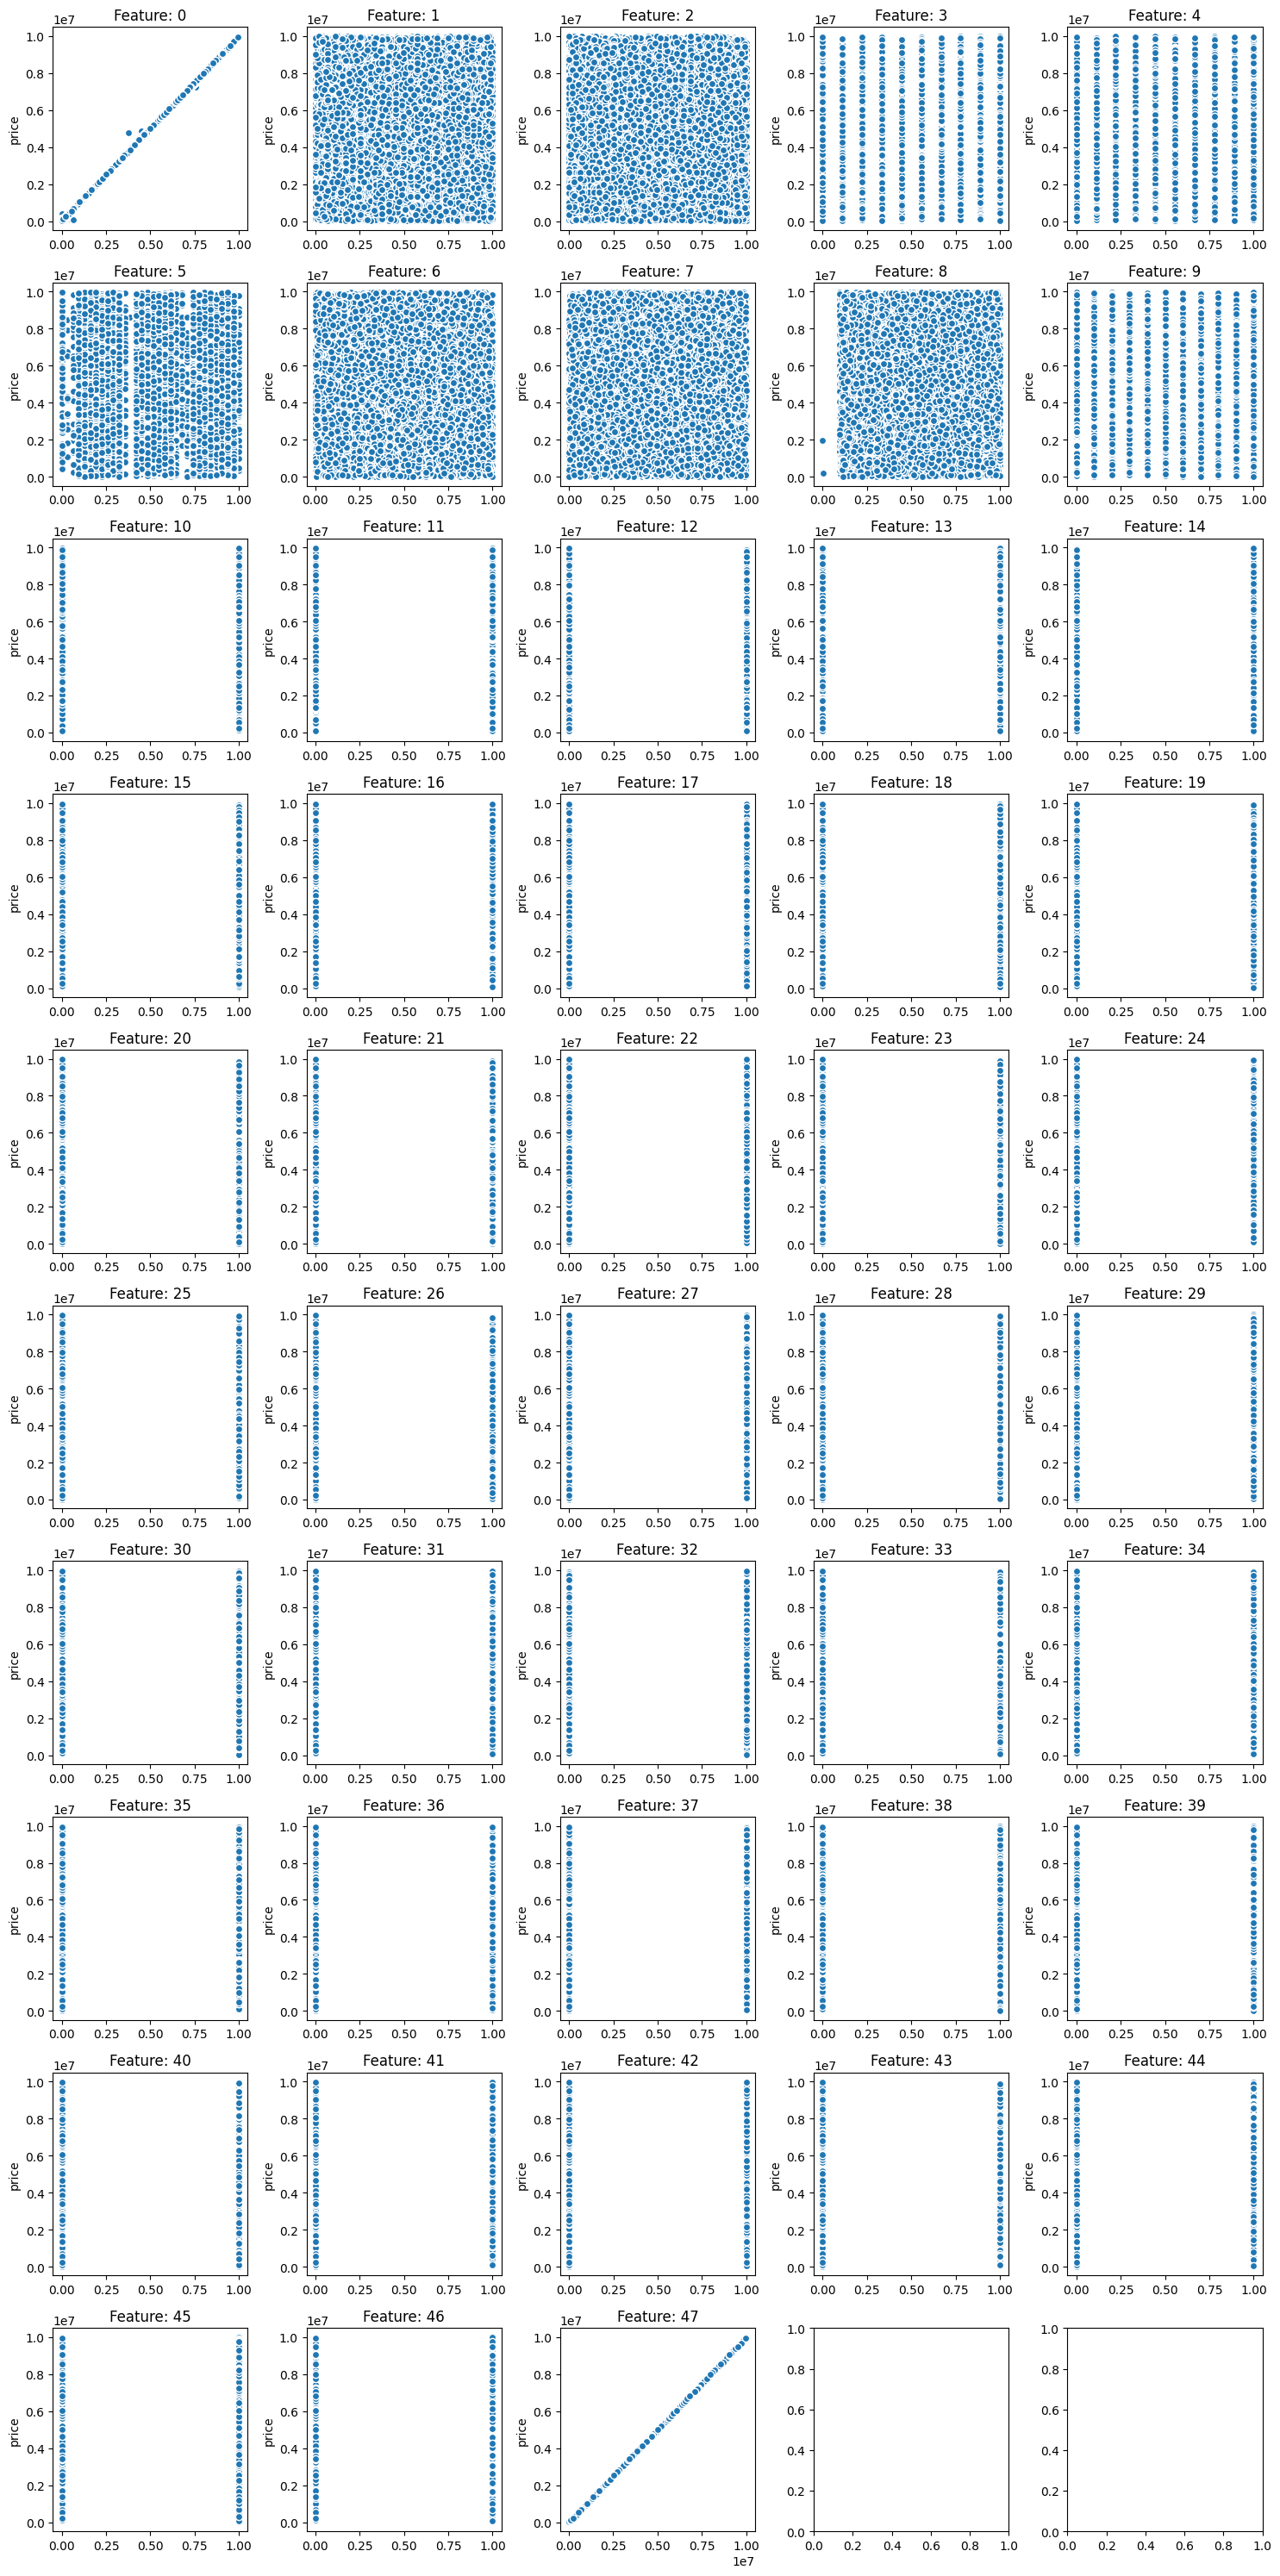

In [25]:
from sklearn_utils import visualize_target_vs_columns

visualize_target_vs_columns(
    pd.concat([df_train, df_val, df_test]),
    target_colname='47',
    columns=df_train.columns
)

In [45]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(n_estimators=50)
rfr.fit(Xs[0], Ys[0])

RandomForestRegressor(n_estimators=50)

In [46]:
report_model(rfr, Xs[0], Ys[0])
report_model(rfr, Xs[1], Ys[1])

4047.017754381542
8606.235143317332


In [47]:
from sklearn.ensemble import RandomForestRegressor
from model import Model

RandomForestModel = Model(
    RandomForestRegressor(n_estimators=80),
    'RF',
    [
        {
            'n_estimators': [200],
            # 'max_depth': [None, 10, df_train.shape[1] // 2]
            # other params
        },
    ],
    [
        {
            'n_estimators': np.arange(5, 300)
        },

    ]
)

In [48]:
all_models = {
    model.name: model
    for model in [
        RandomForestModel,
    ]
}

### RandomizedSearchCV

In [49]:
from sklearn.model_selection import RandomizedSearchCV

rfr_randomized = RandomizedSearchCV(
    RandomForestRegressor(),
    {
        'n_estimators': np.arange(10, 200),
        # 'criterion': ['squared_error', 'absolute_error', 'friedman_mse', 'poisson'],
        # 'max_depth': np.arange(2, df_train.shape[1]),
        # 'min_samples_split': np.linspace(0.01, 0.99, 10),
        # 'max_features': ['sqrt', 'log2'],
        'random_state': np.arange(100),
        'warm_start': [True, False]
    },
    cv=3,
    n_iter=10,
    scoring='neg_mean_squared_error',
    verbose=5
)

In [51]:
rfr_randomized_res = rfr_randomized.fit(
    X_train,
    Y_train,
)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3] END n_estimators=57, random_state=85, warm_start=False;, score=-84190129.846 total time=   7.8s
[CV 2/3] END n_estimators=57, random_state=85, warm_start=False;, score=-175003238.377 total time=   5.5s
[CV 3/3] END n_estimators=57, random_state=85, warm_start=False;, score=-110436951.533 total time=   5.1s
[CV 1/3] END n_estimators=21, random_state=31, warm_start=True;, score=-79750531.036 total time=   1.7s
[CV 2/3] END n_estimators=21, random_state=31, warm_start=True;, score=-178848975.811 total time=   1.7s
[CV 3/3] END n_estimators=21, random_state=31, warm_start=True;, score=-111864918.846 total time=   1.7s
[CV 1/3] END n_estimators=157, random_state=80, warm_start=True;, score=-80467077.483 total time=  14.0s
[CV 2/3] END n_estimators=157, random_state=80, warm_start=True;, score=-175094769.900 total time=  14.0s
[CV 3/3] END n_estimators=157, random_state=80, warm_start=True;, score=-111468280.277 total time

In [53]:
report_model(rfr_randomized_res.best_estimator_, X_train, Y_train)
report_model(rfr_randomized_res.best_estimator_, X_val, Y_val)

3928.000113018757
9465.670591736272


In [54]:
rfr_randomized_res.best_params_

{'warm_start': True, 'random_state': 38, 'n_estimators': 184}

### GridSearchCV

Fitting RF
Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV 1/2] END n_estimators=200;, score=(train=-17283197.361, test=-69147731.928) total time=  13.3s
[CV 2/2] END n_estimators=200;, score=(train=-9047498.173, test=-112483752.729) total time=  12.5s


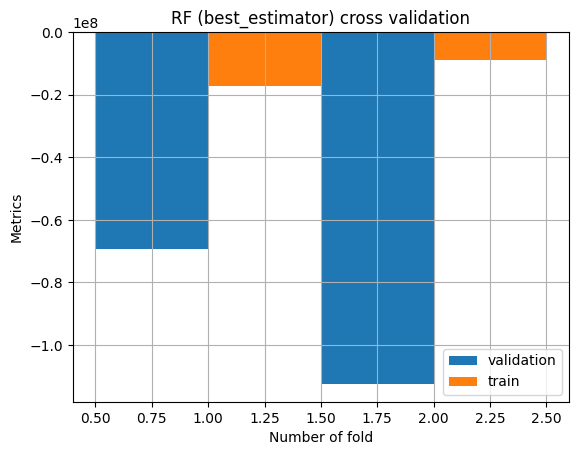

In [ ]:
from sklearn_utils import dict_subset
from sklearn_utils import (
    fit_grid_search,
    fit_randomized_search
)

rf_gridsearch_results = fit_grid_search(
    dict_subset(all_models, ['RF']),
    X_=X_train,  # X_trainval,
    Y_=Y_train,  # Y_trainval,
    cv_=2,
    scoring_='neg_mean_squared_error',
    verbose=3,
    to_put_minus=True
)

In [ ]:
report_model(rf_gridsearch_results['RF'].best_estimator_, X_train, Y_train)
report_model(rf_gridsearch_results['RF'].best_estimator_, X_val, Y_val)

3648.6598115769893
9998.503683088782


In [ ]:
rf_gridsearch_results['RF'].best_params_

{'n_estimators': 200}

## SVM

In [ ]:
from sklearn.svm import SVR

svr = SVR()
svr.fit(X_train, Y_train)

SVR()

In [ ]:
report_model(svr, X_train, Y_train)

2935719.573051039


## Linear regression

In [55]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_train, Y_train)

LinearRegression()

In [56]:
report_model(lin_reg, X_train, Y_train)
report_model(lin_reg, X_val, Y_val)

10421.971238566759
11482.73138178704


## Elastic net

### RandomizedSearchCV

In [61]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import ElasticNet


elastic_net_randomized = RandomizedSearchCV(
    ElasticNet(),
    param_distributions={
        'alpha': np.linspace(0.01, 1.0, num=15),
        'l1_ratio': np.linspace(0, 1.0, num=15),
        'warm_start': [False, True],
        'random_state': np.arange(1000)
    },
    n_iter=50,
    scoring='neg_mean_squared_error',
    cv=4,
    verbose=1,
)

In [62]:
elastic_net_randomized_res = elastic_net_randomized.fit(X_train, Y_train)

Fitting 4 folds for each of 50 candidates, totalling 200 fits


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.067e+16, tolerance: 9.266e+12 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.021e+16, tolerance: 9.149e+12 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode

In [63]:
report_model(elastic_net_randomized_res.best_estimator_, X_train, Y_train), \
    elastic_net_randomized_res.best_estimator_, \
    report_model(elastic_net_randomized_res.best_estimator_, X_val, Y_val)

10422.006697942228
11481.7753958726


(None,
 ElasticNet(alpha=0.8585714285714285, l1_ratio=1.0, random_state=284),
 None)

## XGBoost

In [65]:
%%capture
!pip install xgboost

In [91]:
from xgboost import XGBRegressor

xgb = XGBRegressor(n_estimators=500, max_depth=3)

In [92]:
xgb.fit(Xs[0], Ys[0])

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [93]:
report_model(xgb, Xs[0], Ys[0])
report_model(xgb, Xs[1], Ys[1])

12655.331073100062
16933.956501468907


## Random search cv

In [97]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV


RANDOM_STATE = 42

xgboost_random_search_est = RandomizedSearchCV(
    estimator=XGBRegressor(),
    param_distributions={
        'n_estimators': np.arange(10, 800),
        'max_depth': np.arange(2, Xs[0].shape[1]),
    },
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=5,
    n_iter=15,
    random_state=RANDOM_STATE
)

In [98]:
xgboost_random_search_res = xgboost_random_search_est.fit(
    Xs[0],
    Ys[0]
)

Fitting 3 folds for each of 15 candidates, totalling 45 fits
[CV 1/3] END max_depth=21, n_estimators=795;, score=-290706890.257 total time= 1.3min
[CV 2/3] END max_depth=21, n_estimators=795;, score=-382972945.905 total time= 1.4min
[CV 3/3] END max_depth=21, n_estimators=795;, score=-382007418.158 total time=  54.8s
[CV 1/3] END max_depth=3, n_estimators=80;, score=-835030359.752 total time=   0.2s
[CV 2/3] END max_depth=3, n_estimators=80;, score=-862883478.429 total time=   0.2s
[CV 3/3] END max_depth=3, n_estimators=80;, score=-913483499.910 total time=   0.2s
[CV 1/3] END max_depth=16, n_estimators=234;, score=-296375421.438 total time=  13.1s
[CV 2/3] END max_depth=16, n_estimators=234;, score=-377538886.289 total time=  16.6s
[CV 3/3] END max_depth=16, n_estimators=234;, score=-384739769.941 total time=  18.0s
[CV 1/3] END max_depth=9, n_estimators=745;, score=-267314311.008 total time=   7.3s
[CV 2/3] END max_depth=9, n_estimators=745;, score=-369641382.614 total time=  10.5s
[

In [99]:
report_model(xgboost_random_search_res.best_estimator_, Xs[0], Ys[0])
report_model(xgboost_random_search_res.best_estimator_, Xs[1], Ys[1])

2374.383151173002
18213.706740612557


In [102]:
np.sqrt(-xgboost_random_search_res.best_score_)

17690.311480073146

# Save the models

In [ ]:
manager.save_models({
    'RF': rf_gridsearch_results['RF'].best_estimator_,
    'ElasticNet': elastic_net_randomized_res.best_estimator_
})

# Make predictions with the best model

## Final report

In [ ]:
from sklearn.ensemble import RandomForestRegressor


best_model = rf_gridsearch_results['RF'].best_estimator_ # elastic_net_randomized_res.best_estimator_ # RandomForestRegressor(n_estimators=100)
best_model.fit(X_train, Y_train)

RandomForestRegressor(n_estimators=200)

In [ ]:
from sklearn.metrics import mean_squared_error

report_model(best_model, X_train, Y_train)
report_model(best_model, X_val, Y_val)

3727.975166981364
10706.419024578174


## Retrain on all available data

In [ ]:
best_model.fit(
    np.vstack([X_train, X_val, X_test]),
    np.concatenate([Y_train, Y_val, Y_test])
)

RandomForestRegressor(n_estimators=200)

# Predict and save predictions

In [ ]:
submission_preds = best_model.predict(X_submission)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


In [ ]:
submission_df = pd.DataFrame(
    {
        'price': submission_preds
    },
    index=submission_index
)
submission_df.head()

,price
id,
22730,4.766993e+06
22731,6.218868e+06
22732,9.068749e+06
22733,1.645013e+06
22734,6.759304e+06


In [ ]:
submission_df.to_csv(
    f'{manager.data_trial_path}/rfr_20_10_23.csv',
    index=True
)